##### import library

In [1]:
# ---- Standard Libraries ----
import os
import random
import pickle
import base64

# ---- Numerical and Scientific Computing ----
import numpy as np
import pandas as pd

# ---- Plotting and Display ----
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display, HTML

# ---- Machine Learning: Scikit-learn ----
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- Statistics ----
from scipy.stats import pearsonr

# ---- Deep Learning: TensorFlow / Keras ----
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# ---- R Integration (rpy2) ----
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr, isinstalled
from rpy2.robjects.vectors import StrVector
import rpy2.robjects.packages as rpackages

# ---- PDF/Image Handling ----
from pdf2image import convert_from_path


2025-08-03 12:48:11.602664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-03 12:48:11.602712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-03 12:48:11.603690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-03 12:48:11.608883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-03 12:48:12.257444: W tensorflow/compiler/tf2

##### Limit GPU usage

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set a cap (in MB) for the first GPU, e.g., 4096 MB = 4 GB
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=2000)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


2025-08-03 12:48:14.052699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2000 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


##### Set the seed

In [3]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=42, enable_tf_determinism=True):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # For CPU-only reproducibility, optional

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    if enable_tf_determinism:
        try:
            tf.config.experimental.enable_op_determinism(True)
        except Exception:
            pass
my_seed = 19
# Usage:
set_seed(my_seed)


##### Load data

In [4]:
# Load data
file_path = fasta_file_path = "../../../data/kgain_all_population_wt.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file '{file_path}' was not found. Please upload the file to the correct path.")

df = pd.read_csv(file_path)[['ref_flank_seq', 'ALT', 'wild_type_kGain']]

##### Delete dupliate entry

In [5]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df

,ref_flank_seq,ALT,wild_type_kGain
0,GTCCACCCGCCGTATTGCG,T,-8.764470
1,ACGGAACGGCTGGCCATTA,T,-11.203187
2,CCAATATCAACATTGTCGC,G,-2.844573
3,CCGGCTCCGGTCGCCAATG,A,-9.244451
4,GCAGCGTATAGCGCGTGGT,G,7.647503
...,...,...,...
34386,TTTTTGAAACGCTCACCGC,T,-4.515558
34387,CGATTTCGAGGCCGAGAAT,A,-1.791759
34388,AGAACTGGTACCGCTGTTA,G,7.409069
34389,GTGTTTGGTCGCGAAGATT,T,-8.417367


##### One-hot encode allele

In [7]:
base_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

##### Helper function

In [8]:
def one_hot_encode(seq, base_to_int={'A': 0, 'C': 1, 'G': 2, 'T': 3}):
    """
    One-hot encode a DNA sequence using a provided base-to-index mapping.

    Parameters
    ----------
    seq : str
        A DNA sequence consisting of nucleotide characters (e.g., 'A', 'C', 'G', 'T').
    base_to_int : dict
        A dictionary mapping each base character to an integer index (0 to 3).
        Example: {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    Returns
    -------
    np.ndarray
        A 2D NumPy array of shape (len(seq), 4), where each row is the one-hot encoded
        representation of the corresponding nucleotide in the input sequence.
        Unrecognized bases will result in a row of zeros.

    Notes
    -----
    - The function assumes exactly 4 output classes corresponding to the columns of the 
      returned array. Extend manually if more bases (e.g., 'N') are needed.
    - Input characters not in `base_to_int` will be encoded as all-zero vectors.
    """
    encoded = np.zeros((len(seq), 4))
    for i, base in enumerate(seq):
        if base in base_to_int:
            encoded[i, base_to_int[base]] = 1
    return encoded


In [9]:
def encode_ref_minus_alt(ref_seq, alt_allele, mut_idx=9):

    """
    Encode a reference DNA sequence into one-hot vectors and subtract the one-hot encoding 
    of the alternate allele at a specified mutation index.

    Parameters
    ----------
    ref_seq : str
        The reference DNA sequence (e.g., "ACGTGACCTGA").
    alt_allele : str
        The alternate allele (a single nucleotide: 'A', 'C', 'G', or 'T') to compare against 
        the reference at the mutation site.
    mut_idx : int, optional
        The index (0-based) in the reference sequence where the mutation occurs. Default is 9.

    Returns
    -------
    np.ndarray
        A 2D NumPy array of shape (len(ref_seq), 4), where each row is the one-hot encoding of 
        the nucleotide at that position. At the mutation index, the value is 
        one_hot(ref_base) - one_hot(alt_allele).

    Notes
    -----
    This encoding emphasizes the difference between the reference and the alternate allele 
    at the mutation site, and keeps other positions unchanged.
    """
    arr = []
    for i, base in enumerate(ref_seq):
        if i == mut_idx:
            ohe = np.array(np.array(one_hot_encode(base) - one_hot_encode(alt_allele)))
        else:
            ohe = np.array(one_hot_encode(base))
        arr.append(ohe)
    return np.array(arr)


In [10]:
def encode_row(row):

    """
    Encode a single row of a DataFrame by computing the one-hot encoded difference 
    between the reference nucleotide and the alternate allele at the mutation site.

    Parameters
    ----------
    row : pandas.Series
        A row from a DataFrame containing at least the following fields:
        - 'ref_flanking_regions': str, the reference DNA sequence with the variant at center.
        - 'Alt_allele': str, the alternate base at the mutation site.

    Returns
    -------
    np.ndarray
        A 2D NumPy array of shape (len(ref_seq), 4), representing one-hot encodings of 
        the reference sequence. At the mutation index, the encoding is:
        one_hot(ref_base) - one_hot(alt_allele)
    
    Notes
    -----
    - Assumes the variant is centered in the `ref_flanking_regions` string.

    """
    ref_seq = row['ref_flank_seq']
    alt_allele = row['ALT']
    mut_idx = len(ref_seq) // 2  # As variant is centered
    return encode_ref_minus_alt(ref_seq, alt_allele, mut_idx)




In [11]:
base_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

##### Prepare input, output for model training

In [12]:
X_encoded = np.stack(df.apply(encode_row, axis=1))
X_encoded = X_encoded.reshape(-1, 19, 4)
y = df['wild_type_kGain'].values.astype(np.float32)

##### Use 80% data for training and 20% for testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

##### Parameters

In [14]:
def focal_regression_loss(gamma=2.0):
    """
    Focal Loss for Regression (without alpha parameter).

    Args:
        gamma (float): Focusing parameter.

    Returns:
        A callable Keras loss function (a closure).
    """
    def loss(y_true, y_pred):
        y_pred = tf.cast(y_pred, y_true.dtype)
        err = tf.abs(y_true - y_pred)
        err = tf.maximum(err, keras.backend.epsilon())
        factor = tf.pow(err, gamma)
        base = err
        
        # Weighted focal loss (per-sample or per-element) - alpha removed, so it's just factor * base
        fl = factor * base
        
        return tf.reduce_mean(fl)
    
    loss.__name__ = f"focal_regression_loss_g{gamma}" # Adjusted name after removing alpha
    return loss


In [15]:
ATTN_SEQ_LEN = 19
ATTN_ONEHOT_DIM = 4
ATTN_EMB_DIM = 32
ATTN_NUM_HEADS = 4
ATTN_FF_DIM = 32
ATTN_NUM_LAYERS = 2
ATTN_DROPOUT_RATE = 0.1
gamma = 2

In [16]:

def build_attention_regressor(
    seq_len=ATTN_SEQ_LEN, onehot_dim=ATTN_ONEHOT_DIM, emb_dim=ATTN_EMB_DIM,
    num_heads=ATTN_NUM_HEADS, ff_dim=ATTN_FF_DIM, num_layers=ATTN_NUM_LAYERS,
    dropout_rate=ATTN_DROPOUT_RATE, return_attention=False, seed=None
):
    inp = keras.Input(shape=(seq_len, onehot_dim), name="seq_onehot_input")
    x = layers.Dense(
        emb_dim,
        kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros()
    )(inp)
    pos_idx = tf.range(seq_len)[tf.newaxis, :]
    pos_emb = layers.Embedding(
        input_dim=seq_len,
        output_dim=emb_dim,
        embeddings_initializer=keras.initializers.GlorotUniform(seed=seed)
    )(pos_idx)
    pos_emb = tf.squeeze(pos_emb, axis=0)
    x = x + pos_emb
    x = layers.Dropout(dropout_rate, seed=seed)(x)
    attention_scores_outputs = []
    for i in range(num_layers):
        attn_layer = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=emb_dim,
            name=f"my_attention_{i}",
            kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
            bias_initializer=keras.initializers.Zeros()
        )
        attn_out, attn_scores = attn_layer(x, x, return_attention_scores=True)
        attention_scores_outputs.append(attn_scores)
        attn_out = layers.Dropout(dropout_rate, seed=seed)(attn_out)
        x = layers.Add()([x, attn_out])
        x = layers.LayerNormalization()(x)
        ff = layers.Dense(
            ff_dim,
            activation='relu',
            kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
            bias_initializer=keras.initializers.Zeros()
        )(x)
        ff = layers.Dropout(dropout_rate, seed=seed)(ff)
        ff = layers.Dense(
            emb_dim,
            kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
            bias_initializer=keras.initializers.Zeros()
        )(ff)
        x = layers.Add()([x, ff])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(
        1,
        activation='linear',
        name="regression_output",
        kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros()
    )(x)
    if return_attention:
        model = keras.Model(inp, [out] + attention_scores_outputs)
    else:
        model = keras.Model(inp, out)
    return model


In [17]:
# # ---- Inference: reload, extract prediction and attention ----
attn_model = build_attention_regressor(return_attention=True, seed=my_seed)
attn_model(tf.zeros((1, ATTN_SEQ_LEN, ATTN_ONEHOT_DIM)))  # build model variables
attn_model.load_weights("attn_regressor_focal.weights.h5")


2025-08-03 12:48:15.714147: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


##### Compute R2, MSE, MAE, correlation for test data

In [18]:
y_pred_ltee = attn_model.predict(X_test)[0].reshape(1, -1)
mse_ltee = mean_squared_error(y_test.ravel(), y_pred_ltee.ravel())
mae_ltee = mean_absolute_error(y_test.ravel(), y_pred_ltee.ravel())
r2_ltee = r2_score(y_test.ravel(), y_pred_ltee.ravel())
corr_ltee, _ = pearsonr(y_test.ravel(), y_pred_ltee.ravel())

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


##### LTEE test data kGain vs predicted kGain

In [19]:
df_ltee = pd.DataFrame(columns=["actual_kgain", "predicted_kgain"])
df_ltee["actual_kgain"] = y_test.ravel()
df_ltee["predicted_kgain"] = y_pred_ltee.ravel()
df_ltee["error"] = df_ltee["actual_kgain"] - df_ltee["predicted_kgain"]
df_ltee.head()

,actual_kgain,predicted_kgain,error
0,-0.423030,-6.357634,5.934604
1,0.461996,7.238190,-6.776194
2,3.930453,3.195794,0.734659
3,0.737483,3.444733,-2.707250
4,-10.917358,-11.173589,0.256230


##### Fig. 8e

R[write to console]: Need help getting started? Try the R Graphics Cookbook:
https://r-graphics.org



`geom_smooth()` using formula = 'y ~ x'
Plot saved: LTEE_actual_vs_predicted.pdf


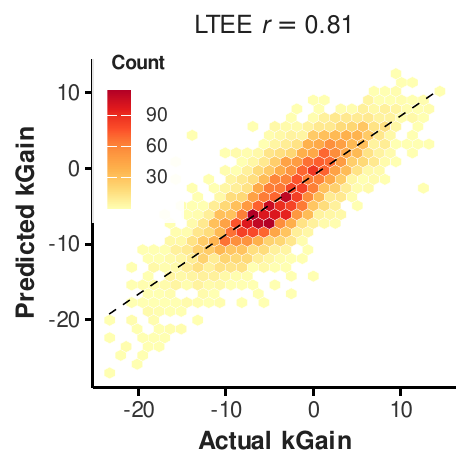

In [20]:


# Activate pandas-R conversion
pandas2ri.activate()
with (ro.default_converter + pandas2ri.converter).context():
    ro.globalenv['df_ltee'] = ro.conversion.get_conversion().py2rpy(df_ltee)

# Install necessary R packages if missing
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

required = ["ggplot2", "hexbin"] # Viridis no longer strictly needed if using custom gradient
to_install = [pkg for pkg in required if not rpackages.isinstalled(pkg)]
if to_install:
    print(f"Installing R package(s): {', '.join(to_install)}...")
    utils.install_packages(StrVector(to_install))
    for pkg in to_install:
        rpackages.importr(pkg)

# Define the filename for the PDF
pdf_filename = "LTEE_actual_vs_predicted.pdf"

# Plotting in R
ro.r(f'''
library(ggplot2); library(hexbin)

r_coeff <- cor(df_ltee$actual_kgain, df_ltee$predicted_kgain, use = "complete.obs")

# Updated title with italic 'r' using bquote
title_expr <- bquote("LTEE " * italic(r) == .(round(r_coeff, 2)))

p <- ggplot(df_ltee, aes(x = actual_kgain, y = predicted_kgain)) +
  geom_hex(bins = 30, aes(fill = after_stat(count)),
           color = "white", linewidth = 0.05) +
  # Regression line with Strong Orange
  geom_smooth(method = "lm", se = FALSE, color = "black", linetype = "dashed", linewidth = 0.25) +
  # Custom gradient from light grey to Strong Blue for hexbin fill
scale_fill_distiller(
  palette = "YlOrRd", direction = 1, name = "Count",
  guide = guide_colorbar(
    barwidth = unit(0.3, "cm"),
    barheight = unit(1.5, "cm"),
    title.position = "top",
    title.hjust = 0.5,
    label.position = "right"
  )
# )
  ) +
  labs(x = "Actual kGain", y = "Predicted kGain", title = title_expr) +
  theme_minimal(base_family = "Helvetica") +
  theme(
    plot.title          = element_text(size = 9, face = "bold", hjust = 0.5, color = "#212121"),
    axis.title          = element_text(size = 9, face = "bold", color = "#212121"),
    axis.text           = element_text(size = 8, color = "grey20"),
    panel.grid          = element_blank(),
    axis.line           = element_line(color = "black", linewidth = 0.5),
    axis.ticks          = element_line(color = "black", linewidth = 0.5),
    panel.border        = element_blank(),
    legend.position     = c(0.25, 0.5),
    legend.justification = c(1, 0),
    legend.title        = element_text(size = 7, face = "bold", color = "#212121"),
    legend.text         = element_text(size = 7, color = "grey20"),
    legend.background   = element_rect(fill = alpha("white", 0.9), color = NA),
    plot.margin         = margin(2, 2, 2, 2, "mm"),
    plot.background = element_rect(fill = "white", color = NA)
  )

ggsave(
  "{pdf_filename}", p,
  width = 6, height = 6, units = "cm", device = cairo_pdf, dpi = 300
)
''')

print(f"Plot saved: {pdf_filename}")

from pdf2image import convert_from_path
pages = convert_from_path(pdf_filename, dpi=200)
from IPython.display import display
display(pages[0]) 


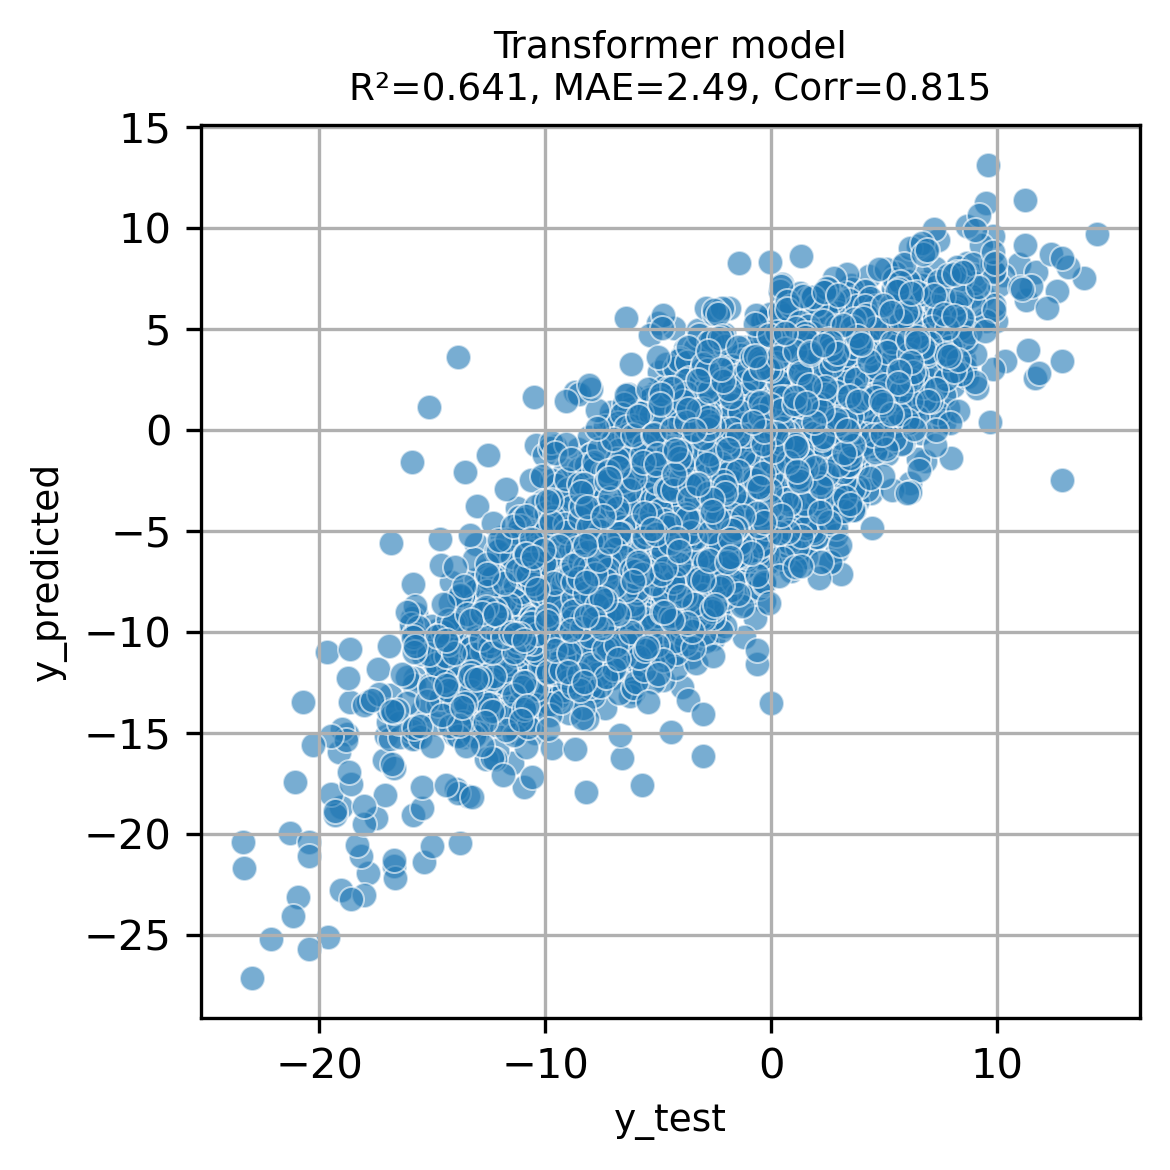

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.figure(figsize=(4, 4), dpi=300)
sns.scatterplot(x=y_test.ravel(), y=y_pred_ltee.ravel(), alpha=0.6)
plt.title(f"Transformer model\nR²={r2_ltee:.3f}, MAE={mae_ltee:.2f}, Corr={corr_ltee:.3f}", fontsize=9)
plt.xlabel("y_test", fontsize=9)
plt.ylabel("y_predicted", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Fig. 8f

In [22]:
# Activate pandas to R dataframe conversion
pandas2ri.activate()

# Updated R function
ro.r('''
plot_error_kde_custom <- function(dataframe, 
                                  output_file="error_kde_plot.pdf", 
                                  width=4, height=3,
                                  text_size=14,
                                  line_color="blue", 
                                  fill_color="skyblue", 
                                  mean_line_color="red") {
    library(ggplot2)
    p <- ggplot(dataframe, aes(x=error)) +
         geom_density(fill=fill_color, alpha=0.5, color=line_color, size=1) +
         geom_vline(aes(xintercept=mean(error)), 
                    color=mean_line_color, linetype="dashed", size=1) +
         theme_minimal(base_size=text_size) +
         theme(panel.grid = element_blank(),
               axis.line = element_line(color = "black"),
               axis.ticks = element_line(color = "black"),
               axis.title = element_text(size=text_size),
               axis.text = element_text(size=text_size * 0.8),
               axis.line.x.top = element_blank(),
               axis.line.y.right = element_blank(),
               axis.ticks.x.top = element_blank(),
               axis.ticks.y.right = element_blank(),
               axis.text.x.top = element_blank(),
               axis.text.y.right = element_blank()) +
         labs(title="Error Distribution (KDE)", x="Error", y="Density")
    ggsave(output_file, p, width=width, height=height)
}
''')


<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7fbc79fa6480> [RTYPES.CLOSXP]
R classes: ('function',)

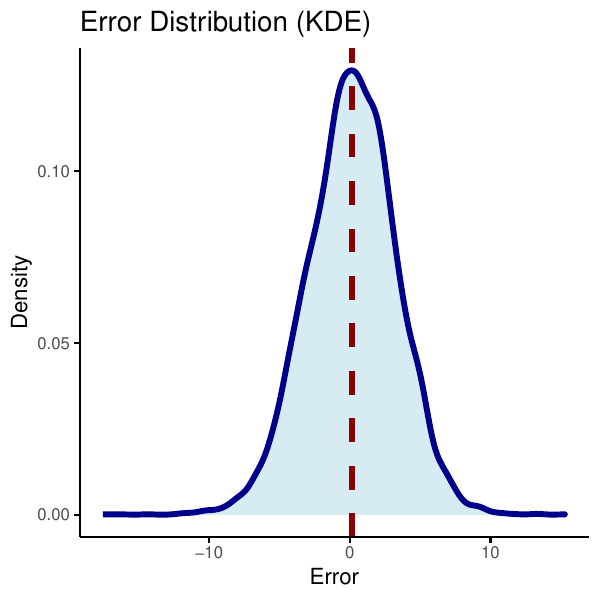

In [23]:
pdf_file = "LTEE_custom_error_plot.pdf"

plot_func = ro.globalenv['plot_error_kde_custom']
plot_func(df_ltee,
          output_file=pdf_file, 
          width=3, height=3, 
          text_size=8,
          line_color="darkblue",
          fill_color="lightblue",
          mean_line_color="darkred")


pages = convert_from_path(pdf_file, dpi=200)
display(pages[0])
